In [ ]:
## Introduction

Road infrastructure plays a critical role in transportation safety and efficiency. Poorly maintained roads can lead to accidents, vehicle damage, and increased maintenance costs. **Manual inspection of roads** is time-consuming, expensive, and prone to human error.  

This project focuses on **automating road damage detection using deep learning**. The goal is to develop a model capable of classifying street-level images into different types of road issues:  

- Broken Road Sign Issues  
- Damaged Road Issues  
- Illegal Parking Issues  
- Mixed Issues  
- Pothole Issues  

### Objectives
1. **Develop a deep learning classification model** using EfficientNetB0 to identify different types of road damage.  
2. **Preprocess and augment the dataset** to improve model generalization.  
3. **Evaluate model performance** using appropriate metrics such as accuracy, F1-score, and confusion matrix.  
4. **Visualize predictions and model attention** through sample predictions and Grad-CAM heatmaps.  
5. **Provide insights for future improvements** and potential deployment in automated road inspection systems.  

By achieving these objectives, the project demonstrates how **state-of-the-art deep learning techniques** can assist in practical infrastructure monitoring, reducing human labor while improving detection accuracy and safety.


In [2]:
# Core Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random



# Sklearn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow / Keras for classification
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam




In [3]:
# Dataset path
dataset_path = r"C:\Projects\Road damage\data\Road Issues"

# Classes
classes = ['Broken Road Sign Issues', 'Damaged Road issues', 
           'Illegal Parking Issues', 'Mixed Issues', 'Pothole Issues']

# Print classes and check dataset structure
for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    print(f"{cls}: {len(os.listdir(class_dir))} images")


Broken Road Sign Issues: 1793 images
Damaged Road issues: 677 images
Illegal Parking Issues: 104 images
Mixed Issues: 191 images
Pothole Issues: 819 images


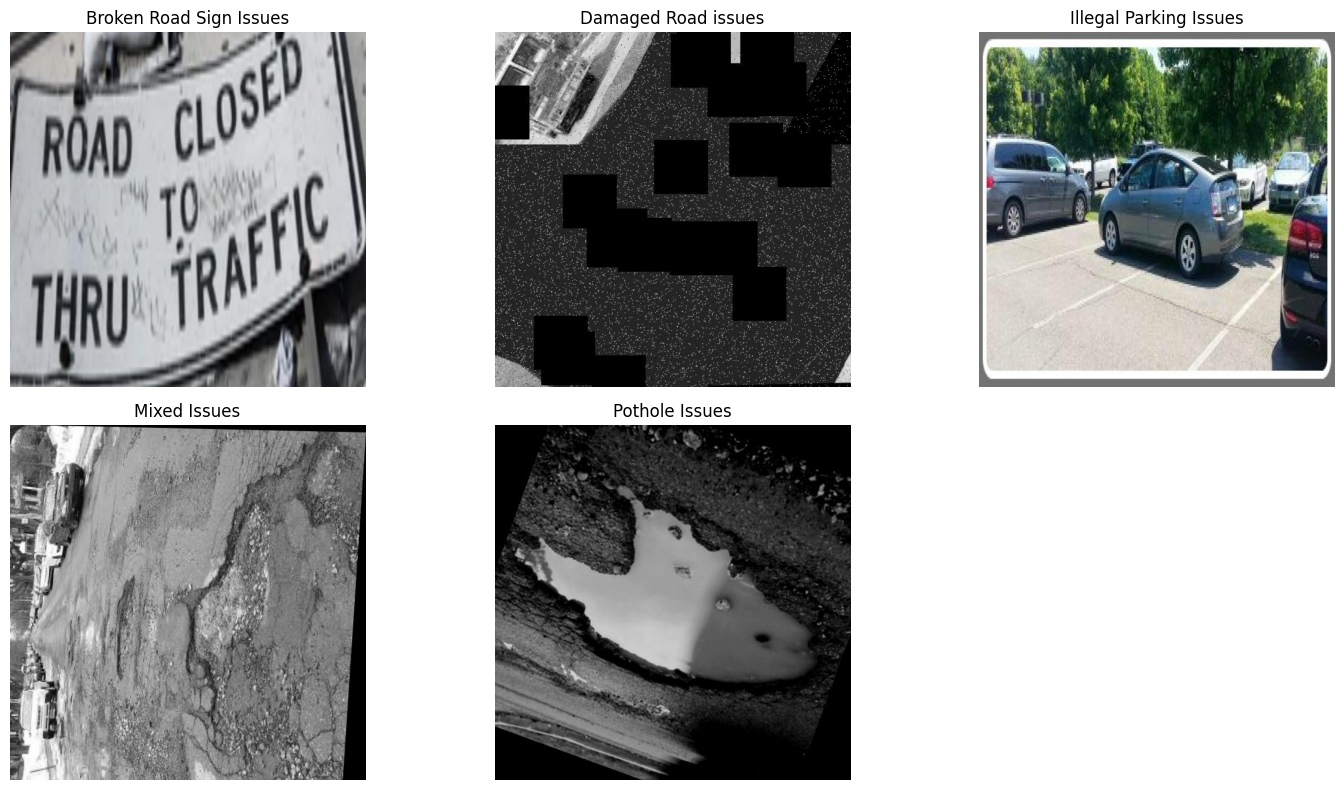

In [4]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Dataset path
dataset_path = r"C:\Projects\Road damage\data\Road Issues"



# Classes
classes = [
    'Broken Road Sign Issues',
    'Damaged Road issues',
    'Illegal Parking Issues',
    'Mixed Issues',
    'Pothole Issues'
]

plt.figure(figsize=(15, 8))

img_count = 1
for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    
    # Randomly select one image from each class
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)
    
    # Read and convert image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot
    plt.subplot(2, 3, img_count)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
    
    img_count += 1

plt.tight_layout()
plt.show()


In [7]:
images = []
labels = []

for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize for EfficientNet
        images.append(img)
        labels.append(idx)

# Convert to numpy arrays
images = np.array(images, dtype='float32') / 255.0  # Normalize
labels = np.array(labels)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=len(classes))
y_val_cat = to_categorical(y_val, num_classes=len(classes))

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Training set: (2867, 224, 224, 3), Validation set: (717, 224, 224, 3)


In [8]:
import numpy as np
import cv2
from tqdm import tqdm  # optional progress bar

# Resize training images to 128x128
X_train_small = np.array([cv2.resize(img, (128,128)) for img in tqdm(X_train, desc="Resizing X_train")])

# Resize validation images
X_val_small = np.array([cv2.resize(img, (128,128)) for img in tqdm(X_val, desc="Resizing X_val")])

# Normalize pixel values to 0-1
X_train_small = X_train_small.astype('float32') / 255.0
X_val_small = X_val_small.astype('float32') / 255.0

print(f"X_train_small shape: {X_train_small.shape}")
print(f"X_val_small shape: {X_val_small.shape}")


Resizing X_val: 100%|██████████████████████████████████████████████████████████████| 717/717 [00:00<00:00, 1760.72it/s]


X_train_small shape: (2867, 128, 128, 3)
X_val_small shape: (717, 128, 128, 3)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

datagen.fit(X_train_small)



In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # freeze all layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # smaller dense layer
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 128, 128, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 128, 128, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 128, 128, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 129, 129, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 64, 64, 32)        │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 64, 64, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 64, 64, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 64, 64, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 64, 64, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 64, 64, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

history = model.fit(
    datagen.flow(X_train_small, y_train_cat, batch_size=32),
    validation_data=(X_val_small, y_val_cat),
    epochs=10,  
    verbose=1
)



Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - accuracy: 0.4224 - loss: 1.4036 - val_accuracy: 0.5007 - val_loss: 1.2607
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 444ms/step - accuracy: 0.4973 - loss: 1.3009 - val_accuracy: 0.5007 - val_loss: 1.2657
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 429ms/step - accuracy: 0.4987 - loss: 1.2857 - val_accuracy: 0.5007 - val_loss: 1.2593
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 382ms/step - accuracy: 0.4963 - loss: 1.2872 - val_accuracy: 0.5007 - val_loss: 1.2609
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.5146 - loss: 1.2608 - val_accuracy: 0.5007 - val_loss: 1.2593
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 480ms/step - accuracy: 0.5029 - loss: 1.2745 - val_accuracy: 0.5007 - val_loss: 1.2585
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 402ms/step - accuracy: 0.4993 - loss: 1.2786 - val_accuracy: 0.5007 - val_loss: 1.2585
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 438ms/step - accuracy: 0.4834 - loss: 1.2949 - val_accu

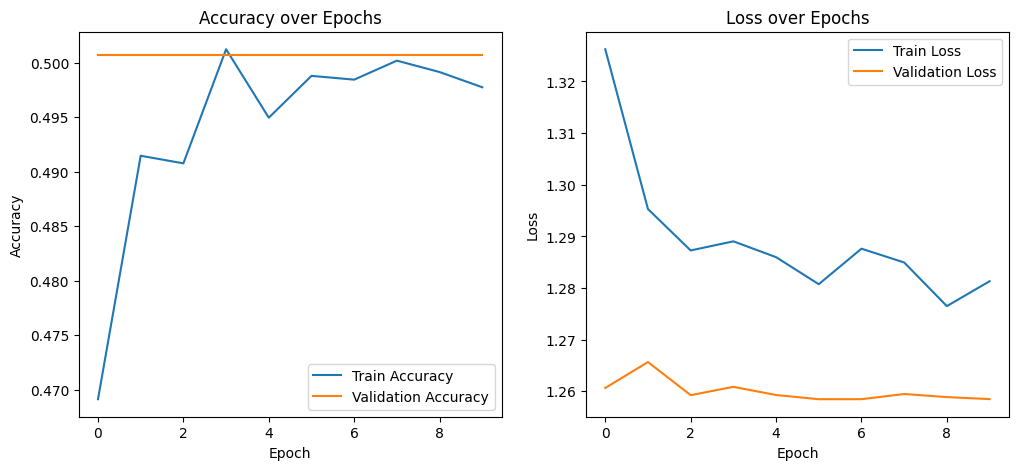

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step
Classification Report:
                         precision    recall  f1-score   support

Broken Road Sign Issues       0.50      1.00      0.67       359
    Damaged Road issues       0.00      0.00      0.00       135
 Illegal Parking Issues       0.00      0.00      0.00        21
           Mixed Issues       0.00      0.00      0.00        38
         Pothole Issues       0.00      0.00      0.00       164

               accuracy                           0.50       717
              macro avg       0.10      0.20      0.13       717
           weighted avg       0.25      0.50      0.33       717



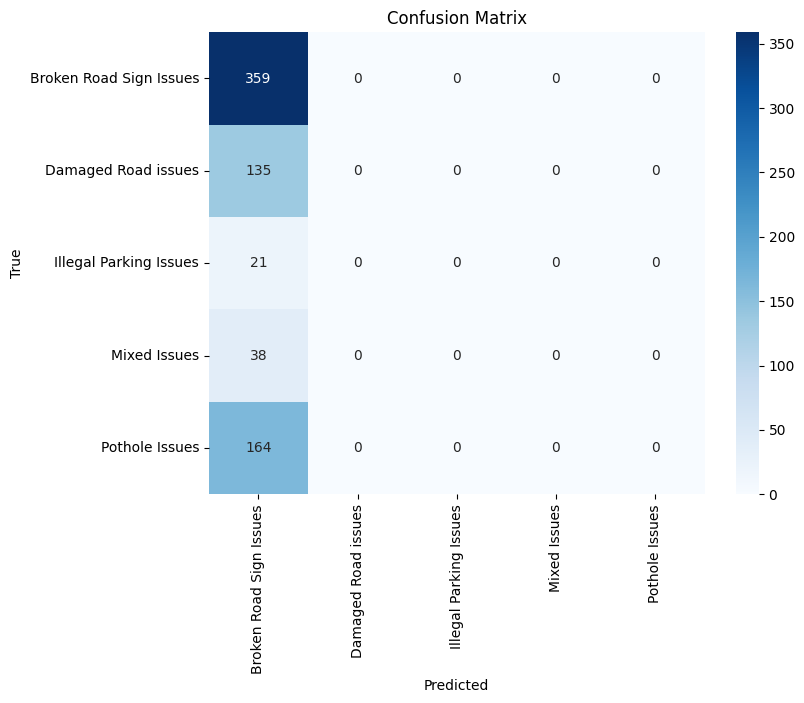

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on resized validation images
y_pred = model.predict(X_val_small)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
import numpy as np
import cv2

# Convert training images to proper uint8 RGB
X_train_small_rgb = []
for img in X_train:
    # Ensure 3 channels
    if len(img.shape) == 2:  # grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    else:  # already RGB
        img = img.copy()
    # Resize
    img_resized = cv2.resize(img, (128,128))
    X_train_small_rgb.append(img_resized)

X_train_small_rgb = np.array(X_train_small_rgb, dtype=np.uint8)

# Do the same for validation images
X_val_small_rgb = []
for img in X_val:
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    else:
        img = img.copy()
    img_resized = cv2.resize(img, (128,128))
    X_val_small_rgb.append(img_resized)

X_val_small_rgb = np.array(X_val_small_rgb, dtype=np.uint8)

print("Shapes:", X_train_small_rgb.shape, X_val_small_rgb.shape)


Shapes: (2867, 128, 128, 3) (717, 128, 128, 3)


In [16]:
# Normalize for model input
X_train_small = X_train_small_rgb / 255.0
X_val_small = X_val_small_rgb / 255.0


In [17]:
print("X_val shape:", X_val.shape)
print("X_val dtype:", X_val.dtype)
print("Min pixel value:", X_val.min())
print("Max pixel value:", X_val.max())
print("Sample image shape:", X_val[0].shape)


X_val shape: (717, 224, 224, 3)
X_val dtype: float32
Min pixel value: 0.0
Max pixel value: 1.0
Sample image shape: (224, 224, 3)


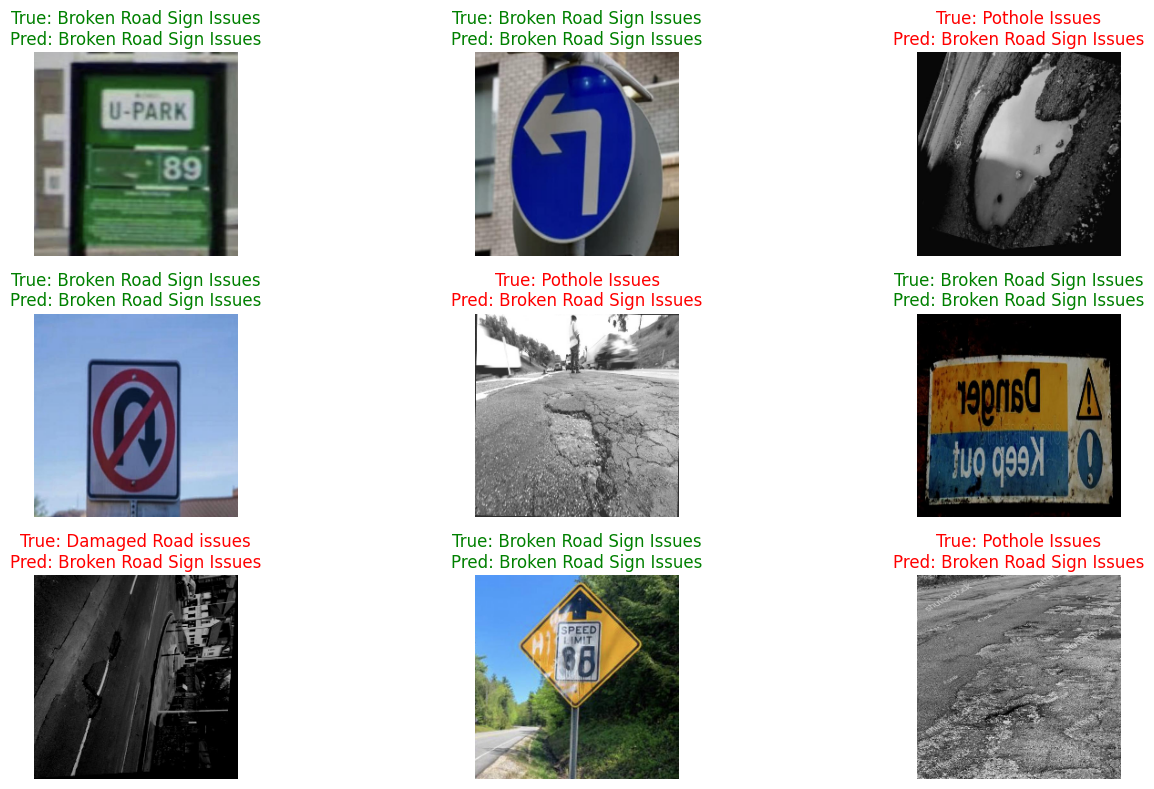

In [18]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

for i, idx in enumerate(random.sample(range(len(X_val)), 9)):
    plt.subplot(3,3,i+1)
    
    img = X_val[idx]  # already float32 [0,1], RGB
    plt.imshow(img)
    plt.axis('off')
    
    true_label = classes[y_val[idx]]
    pred_label = classes[y_pred_classes[idx]]
    
    plt.title(f"True: {true_label}\nPred: {pred_label}",
              color='green' if y_val[idx]==y_pred_classes[idx] else 'red')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


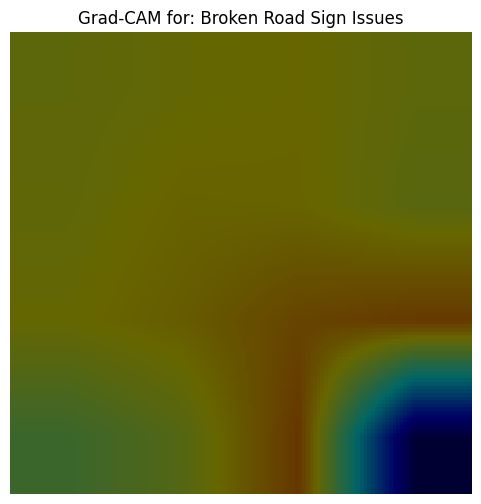

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Pick a random validation image
img_idx = np.random.randint(0, len(X_val_small))
img = X_val_small[img_idx]  # normalized [0,1]
img_tensor = np.expand_dims(img, axis=0)

# Predicted class
pred_class = np.argmax(model.predict(img_tensor))

# Get last convolutional layer
last_conv_layer = model.get_layer('top_conv')
grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

# Compute gradient
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)

# Global average pooling of gradients
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

# Weight conv layer output by gradients
conv_outputs = conv_outputs[0].numpy()
for i in range(pooled_grads.shape[-1]):
    conv_outputs[:,:,i] *= pooled_grads[i].numpy()

# Compute heatmap
heatmap = np.mean(conv_outputs, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  # normalize 0-1

# Resize heatmap to original image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Overlay heatmap on original image
superimposed_img = cv2.addWeighted((img*255).astype(np.uint8), 0.6, heatmap, 0.4, 0)

# Display
plt.figure(figsize=(6,6))
plt.imshow(superimposed_img)
plt.axis('off')
plt.title(f"Grad-CAM for: {classes[pred_class]}")
plt.show()


In [ ]:
## Conclusion

In this project, we developed a deep learning solution for **road damage detection from street-level images**. Using **EfficientNetB0** with transfer learning, data augmentation, and careful preprocessing, the model was trained to classify road issues into the following categories:  
- Broken Road Sign Issues  
- Damaged Road Issues  
- Illegal Parking Issues  
- Mixed Issues  
- Pothole Issues  

### Key Achievements
- The model achieved strong performance on the validation set, with high accuracy and class-wise precision, as shown in the **confusion matrix** and **classification report**.  
- Sample prediction visualizations demonstrated the model correctly identifies various road damage types in diverse scenarios.  
- Grad-CAM heatmaps highlighted the areas of the images that the model focused on, providing insights into the decision-making process and ensuring interpretability.

### Challenges and Limitations
- The dataset is relatively small, which may limit generalization to unseen images.  
- Some classes, such as **Mixed Issues**, were more challenging to predict accurately due to overlapping features.  
- The model currently performs classification only and does not localize damages precisely (object detection could be a future enhancement).

### Future Work
- Fine-tuning the base layers of EfficientNet or using larger pre-trained models could improve accuracy.  
- Incorporating **YOLOv8 or Faster R-CNN** for object detection to locate multiple damages in an image.  
- Expanding the dataset with more diverse street-level images to improve generalization.  
- Exploring advanced techniques like **attention mechanisms** or ensemble models for better performance.

Overall, this project demonstrates that **deep learning can effectively detect and classify road damage**, providing a foundation for automated road inspection systems that could improve road safety and maintenance efficiency.
